In [212]:
import markhov
import em
import pandas_functions
import numpy as np
import pandas as pd
from florisplotlib import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Demonstrating EM

Here we demonstrate the use and behaviour of the various functions in our expectation maximisation algorithm for learning rule probagbilities for a two-part grammar made up of a finite state automaton that generates strings of operations and a bigram grammar of legal transitions for the operation Merge.

### Get set up

Some functions for log-transforming the grammar

Make some transitions

In [59]:
trans = {'a':['a','b'],
           'b':['b','a'],
           '[':['a','b']
       }


In [60]:
trans_probs = {'a':{'a':0.5,'b':0.5},
           'b':{'b':0.5,'a':0.5},
           '[':{'a':0.5,'b':0.5}
       }

trans_probs=markhov.fsa_log(trans_probs)

Operations FSA

In [141]:
ops = {'S':[('NotCL','mg')], # from start we have to merge
       'NotCL':[('NotCL','mg'),('NotCL','copy'), # this state is the state in which the last "special" operation was *not* Clear. Either we've done none or the last was copy. From here we can do everything including end
               ('CLEAR_S','clear'), # go here to clear the buffer
               ('F','end') # go here to end
           ],
       'CLEAR_S':[('CLEAR','mg')], # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':[('CLEAR','mg'), # the last special op was Clear so we can Copy or Merge.
                ('NotCL','copy') # if we Copy, the last special op was Copy so go to NotCL
            ],
       'F':[] #final state
   }

# no copy
ops_nc = {'S':[('S','mg'),('F','end')],
          'F':[]}

In [62]:
ops_probs=em.initialise(ops)

Corpora

In [136]:
aaa = ['a','a a','a a a']
aaaa=aaa+['a a a a','a a a a a']

### Parse a sentence

In [64]:
s=aaa[-1]

In [65]:
parses=markhov.parse(s,trans,ops)

In [66]:
for i in range(len(parses)):
    print(markhov.parse2string(parses[i]))


bigrams: [ a a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg mg mg end
k: 3

bigrams: [ a a
buffer: a a a
op states: S NotCL NotCL NotCL F
operations: mg copy mg end
k: 3

bigrams: [ a a
buffer: a a
op states: S NotCL CLEAR_S CLEAR NotCL F
operations: mg clear mg copy end
k: 3


### Parse the corpus

In [67]:
parsed_corpus=em.parse_corpus(aaa,trans,ops)

In [68]:
print(em.parsed_corpus2string(parsed_corpus))


Parse 0:
Sentence: 0
bigrams: [ a
Q: S NotCL F
E: mg end
SC:
  S 1
  F 1
  NotCL 1
TC:
  S mg NotCL 1
  NotCL end F 1
UC:
  [ 1
BC:
  [ a 1

Parse 1:
Sentence: 1
bigrams: [ a a
Q: S NotCL NotCL F
E: mg mg end
SC:
  S 1
  F 1
  NotCL 2
TC:
  NotCL mg NotCL 1
  S mg NotCL 1
  NotCL end F 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 2:
Sentence: 1
bigrams: [ a
Q: S NotCL NotCL F
E: mg copy end
SC:
  S 1
  F 1
  NotCL 2
TC:
  S mg NotCL 1
  NotCL end F 1
  NotCL copy NotCL 1
UC:
  [ 1
BC:
  [ a 1

Parse 3:
Sentence: 2
bigrams: [ a a a
Q: S NotCL NotCL NotCL F
E: mg mg mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL mg NotCL 2
  S mg NotCL 1
  NotCL end F 1
UC:
  a 2
  [ 1
BC:
  [ a 1
  a a 2

Parse 4:
Sentence: 2
bigrams: [ a a
Q: S NotCL NotCL NotCL F
E: mg copy mg end
SC:
  S 1
  F 1
  NotCL 3
TC:
  NotCL mg NotCL 1
  S mg NotCL 1
  NotCL end F 1
  NotCL copy NotCL 1
UC:
  a 1
  [ 1
BC:
  [ a 1
  a a 1

Parse 5:
Sentence: 2
bigrams: [ a a
Q: S NotCL CLEAR_S CLEAR NotCL F
E: mg clear mg cop

Make a parallel list of parse relative probabilities

In [69]:
parse_probs=em.get_p_parses(parsed_corpus,ops_probs,trans_probs)

In [70]:
print(parse_probs)

[1.0, 0.98465847043692245, 0.015341529563077239, 0.87108904807268661, 0.013572054457775594, 0.11533889746953735]


In [71]:
exp_bigrams = em.expected_transition_counts(parsed_corpus,parse_probs,trans,'bc')
exp_unigrams = em.expected_state_counts(parsed_corpus,parse_probs,trans,'uc')

In [72]:
for u in exp_unigrams:
    print ('\nExpected count of %s in each sentence:'%u)
    for s in exp_unigrams[u]:
        print (' %s: %.4f'%(s,exp_unigrams[u][s]))


Expected count of a in each sentence:
 0: 0.0000
 1: 0.9847
 2: 1.8711

Expected count of [ in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [73]:
for a in exp_bigrams:
    for b in exp_bigrams[a]:
        print ('\nExpected count of %s %s in each sentence:'%(a,b))
        for s in exp_bigrams[a][b]:
            print (' %s: %.4f'%(s,exp_bigrams[a][b][s]))


Expected count of a a in each sentence:
 0: 0.0000
 1: 0.9847
 2: 1.8711

Expected count of a b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of [ a in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of [ b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of b a in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000

Expected count of b b in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [74]:
exp_tr = em.expected_transition_counts(parsed_corpus,parse_probs,ops,'tc')
exp_states = em.expected_state_counts(parsed_corpus,parse_probs,ops,'sc')

In [75]:
for u in exp_states:
    print ('\nExpected count of %s in each sentence:'%u)
    for s in exp_states[u]:
        print (' %s: %.4f'%(s,exp_states[u][s]))


Expected count of S in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of NotCL in each sentence:
 0: 1.0000
 1: 2.0000
 2: 2.8847

Expected count of CLEAR_S in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.1153

Expected count of CLEAR in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.1153

Expected count of F in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000


In [76]:
for a in exp_tr:
    for (b,e) in exp_tr[a]:
        print ('\nExpected count of (%s %s %s) in each sentence:'%(a,e,b))
        for s in exp_tr[a][(b,e)]:
            print (' %s: %.4f'%(s,exp_tr[a][(b,e)][s]))


Expected count of (S mg NotCL) in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of (NotCL end F) in each sentence:
 0: 1.0000
 1: 1.0000
 2: 1.0000

Expected count of (NotCL copy NotCL) in each sentence:
 0: 0.0000
 1: 0.0153
 2: 0.0136

Expected count of (NotCL mg NotCL) in each sentence:
 0: 0.0000
 1: 0.9847
 2: 1.7558

Expected count of (NotCL clear CLEAR_S) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.1153

Expected count of (CLEAR_S mg CLEAR) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.1153

Expected count of (CLEAR copy NotCL) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.1153

Expected count of (CLEAR mg CLEAR) in each sentence:
 0: 0.0000
 1: 0.0000
 2: 0.0000


In [86]:
new_ops = em.update(exp_states,exp_tr,ops)

In [87]:
print (markhov.fsa2string(new_ops,False)) # False prints the non-log probs



S
  NotCL mg	1.00

NotCL
  F end	0.51
  NotCL copy	0.00
  NotCL mg	0.47
  CLEAR_S clear	0.02

CLEAR_S
  CLEAR mg	1.00

CLEAR
  NotCL copy	1.00
  CLEAR mg	0.00

F


In [98]:
em.check_fsa(new_ops) # is this a valid probability distribution?

True

In [103]:
em.smooth(new_ops,0.01)

{}


{'CLEAR': {('CLEAR', 'mg'): -5.2983173665480363,
  ('NotCL', 'copy'): -0.0050125418235443695},
 'CLEAR_S': {('CLEAR', 'mg'): 5.5511151231257827e-17},
 'F': {},
 'NotCL': {('CLEAR_S', 'clear'): -3.8210895445546367,
  ('F', 'end'): -0.67884600896123126,
  ('NotCL', 'copy'): -4.9111184038561202,
  ('NotCL', 'mg'): -0.76888445463787891},
 'S': {('NotCL', 'mg'): 5.5511151231257827e-17}}

In [89]:
new_trans = em.update(exp_unigrams,exp_bigrams,trans)

In [90]:
print (markhov.fsa2string(new_trans))



a
  a	0.00
  b	-inf

[
  a	0.00
  b	-inf

b
  a	-0.69
  b	-0.69


In [91]:
em.check_fsa(new_trans) # check this is a valid probability distribution

True

In [104]:
reload(em)

<module 'em' from 'em.py'>

In [97]:
em.smooth(new_trans,0.01)

{'a': -0.0050125418235443695, 'b': -5.2983173665480363}
{'a': -0.0050125418235443695, 'b': -5.2983173665480363}
{'a': -0.69314718055994529, 'b': -0.69314718055994529}


{'[': {'a': -0.0050125418235443695, 'b': -5.2983173665480363},
 'a': {'a': -0.0050125418235443695, 'b': -5.2983173665480363},
 'b': {'a': -0.69314718055994529, 'b': -0.69314718055994529}}

## Expectation Maximisation time!

In [267]:
n = 10 # number of EM iterations to do

In [276]:
history,corpus=em.em(aaa,trans,ops,n) # run EM


In [278]:
#for i,step in enumerate(history):
#    print ('\n--------\n--------\nIteration %i'%i)
#    print ('FSA:')
#    print (markhov.fsa2string(step['fsa']))
#    print ('\n------\nTrans probs:')
#    print (markhov.trans2string(step['trans_probs']))

Display the results

In [279]:
df_ops=pandas_functions.ops_table(history,ops)
df_ops

,rule,p.iteration000,p.iteration001,p.iteration002,p.iteration003,p.iteration004,p.iteration005,p.iteration006,p.iteration007,p.iteration008,p.iteration009,p.iteration010,p.iteration011
0,S->mg NotCL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CLEAR->mg CLEAR,-1.289243,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,CLEAR->copy NotCL,-0.322245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CLEAR_S->mg CLEAR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NotCL->mg NotCL,-1.939126,-2.789772,-2.687231,-2.554356,-2.406219,-2.257223,-2.111620,-1.970846,-1.835598,-1.706345,-1.583443,-1.467187
5,NotCL->copy NotCL,-1.123411,-1.508473,-1.773973,-1.882266,-1.953380,-2.022689,-2.099876,-2.188534,-2.290799,-2.408435,-2.543076,-2.696268
6,NotCL->clear CLEAR_S,-1.523910,-1.931862,-1.743833,-1.714750,-1.722045,-1.740838,-1.766143,-1.797455,-1.835518,-1.881615,-1.937439,-2.005101
7,NotCL->end F,-1.161094,-0.557849,-0.532008,-0.527625,-0.528735,-0.531561,-0.535297,-0.539808,-0.545132,-0.551349,-0.558553,-0.566826


In [280]:
df_ops.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

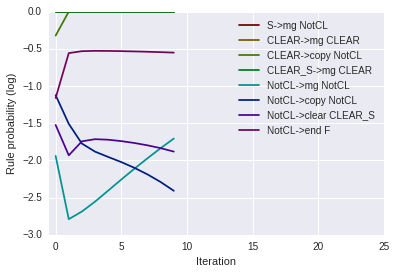

In [281]:
ncol,_ = df_ops.shape
colors = get_colors(ncol)
for i,row in df_ops.iterrows():
    col = colors[i]
    plot(range(n),[ row["p.iteration%03d"%i] for i in range(n) ],'-',color=col,label=row[" rule"])
legend()
xlim(-.5,n+15)
xlabel("Iteration")
ylabel("Rule probability (log)")

Same for the transitions

In [282]:
df_bis=pandas_functions.trans_probs_table(history,trans)
df_bis

,rule,p.iteration0,p.iteration1,p.iteration10,p.iteration11,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9
0,"a,a",-1.842704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"a,b",-0.172437,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,"[,a",-0.333825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"[,b",-1.259412,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,"b,b",-0.376815,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147
5,"b,a",-1.158499,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147,-0.693147


In [283]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_aaa'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [284]:
em.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4.5037946618941653

Make a dataframe of the LL of the corpus throughout training:

In [285]:
df_lls=pandas_functions.ll_corpus_table(history)
df_lls

,iteration,likelihood
0,0,-8.953912
1,1,-4.755626
2,2,-4.687978
3,3,-4.672661
4,4,-4.658820
5,5,-4.643236
6,6,-4.625582
7,7,-4.605737
8,8,-4.583630
9,9,-4.559240


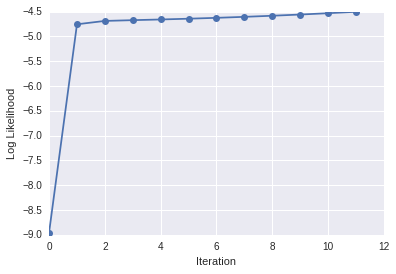

In [286]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")

Look at the changing relative probabilities of the parses

In [287]:
df_parses=pandas_functions.p_parses_table(parsed_corpus,history)
df_parses

,sentence,E,Q,bigrams,iteration_1 p,iteration_10 p,iteration_11 p,iteration_2 p,iteration_3 p,iteration_4 p,iteration_5 p,iteration_6 p,iteration_7 p,iteration_8 p,iteration_9 p
0,0: a,mg end,S NotCL F,[ a,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1: a a,mg mg end,S NotCL NotCL F,[ a a,0.065472,0.668651,0.723048,0.217329,0.286334,0.338029,0.388686,0.441634,0.497064,0.554208,0.611875
2,1: a a,mg copy end,S NotCL NotCL F,[ a,0.934528,0.331349,0.276952,0.782671,0.713666,0.661971,0.611314,0.558366,0.502936,0.445792,0.388125
3,2: a a a,mg mg mg end,S NotCL NotCL NotCL F,[ a a a,0.015761,0.163434,0.208230,0.023263,0.024255,0.030542,0.040719,0.054703,0.073085,0.096713,0.126523
4,2: a a a,mg copy mg end,S NotCL NotCL NotCL F,[ a a,0.224971,0.080989,0.079759,0.083777,0.060453,0.059811,0.064042,0.069162,0.073948,0.077793,0.080256
5,2: a a a,mg clear mg copy end,S NotCL CLEAR_S CLEAR NotCL F,[ a a,0.759268,0.755577,0.712010,0.892960,0.915292,0.909648,0.895239,0.876136,0.852967,0.825494,0.793221


In [351]:
reload(em)
reload(pandas_functions)

<module 'pandas_functions' from 'pandas_functions.py'>

In [352]:
sc=0.01 # smoothing constant

In [353]:
ll_test,parsed_train,parsed_test,history = em.em_train(aaa,aaaa,trans,ops,n,sc)

LL training corpus: -4.37
LL testing corpus: -10.58


In [354]:
df_test = pandas_functions.ll_table(history)
df_test

,iteration,test LL,train LL
0,0,-19.810523,-8.711500
1,1,-10.790639,-4.651683
2,2,-10.756164,-4.609596
3,3,-10.735537,-4.580058
4,4,-10.716377,-4.552463
5,5,-10.696212,-4.524367
6,6,-10.674685,-4.495276
7,7,-10.652034,-4.465259
8,8,-10.628769,-4.434641
9,9,-10.605558,-4.403957


In [355]:
compare = em.compare(aaaa,bbbb,trans,ops,ops_nc,10)


Copy
LL training corpus: -10.12
LL testing corpus: -40.54
Copy LL test corpus: -40.54

No Copy
LL training corpus: -11.32
LL testing corpus: -44.67
No Copy LL test corpus: -44.67

Copy > No copy
Difference: 4.13 = e^4.129 ~ 62.110023



In [356]:
print ('LL test corpus, Copy grammar:\t%.3f'%compare[0][0])
print ('LL test corpus, No-Copy grammar:%.3f'%compare[1][0])

LL test corpus, Copy grammar:	-40.541
LL test corpus, No-Copy grammar:-44.670


In [357]:
df_copy = pandas_functions.ll_table(compare[0][1])
df_no_copy =pandas_functions.ll_table(compare[1][1])

In [358]:
df_copy

,iteration,test LL,train LL
0,0,-17.693176,-20.099674
1,1,-39.958644,-10.438052
2,2,-39.948486,-10.335177
3,3,-39.992667,-10.281554
4,4,-40.056984,-10.246711
5,5,-40.130510,-10.220542
6,6,-40.208845,-10.198623
7,7,-40.289956,-10.178733
8,8,-40.372784,-10.159692
9,9,-40.456683,-10.140870


In [359]:
df_no_copy

,iteration,test LL,train LL
0,0,-44.107318,-20.010798
1,1,-44.670093,-11.322223
2,2,-44.670093,-11.322223


In [360]:
bbbb=['b','b b','b b b','b b b b','b b b b b']

asbs = ['a b','b a','a a b', 'b b a','a b a b a b']

ab=aaaa+bbbb

for s in ab:
    print (s)

a
a a
a a a
a a a a
a a a a a
b
b b
b b b
b b b b
b b b b b


In [361]:
n=10
w = 2
sc=0.01
window = em.windows(ab,trans,ops,ops_nc,n,w,sc)


Window 1 of 2
0
5

Copy
LL training corpus: -10.32
LL testing corpus: -39.50
Copy LL test corpus: -39.50

No Copy
LL training corpus: -11.32
LL testing corpus: -44.67
No Copy LL test corpus: -44.67

Copy > No copy
Difference: 5.17 = e^5.171 ~ 176.114477


Window 2 of 2
5
10

Copy
LL training corpus: -10.31
LL testing corpus: -39.51
Copy LL test corpus: -39.51

No Copy
LL training corpus: -11.32
LL testing corpus: -44.67
No Copy LL test corpus: -44.67

Copy > No copy
Difference: 5.16 = e^5.157 ~ 173.575308


 2 for copy, 0 for no copy


In [332]:
reload(em)

<module 'em' from 'em.py'>

In [373]:
window[0][1][0][1][0]['fsa']

{'CLEAR': {('CLEAR', 'mg'): -0.72978672298867397,
  ('NotCL', 'copy'): -0.65780278053425878},
 'CLEAR_S': {('CLEAR', 'mg'): 0.0},
 'F': {},
 'NotCL': {('CLEAR_S', 'clear'): -1.4429355965254786,
  ('F', 'end'): -1.0170068976337372,
  ('NotCL', 'copy'): -1.2012969945493064,
  ('NotCL', 'mg'): -2.289796484279552},
 'S': {('NotCL', 'mg'): 0.0}}